# Big Data in Finance: Part IV <BR><BR> Lecture Notes 4: Merge CRSP and Compustat 
    
**Instructor** <BR>
Kirsten Burr, kburr26@gsb.columbia.edu
    
**TA's:** <BR>
Dian Jiao, dj2526@columbia.edu <BR>
Varuun Deshpande, vdeshpande25@gsb.columbia.edu
    
<sub> Credit: lecture notes originally developed by Lira Mota

## Objective:
    
Create a final data set called "stock_annual" that has both crsp (permno/permco) and compustat (gvkey) identifiers.

## Set Up

In [1]:
#%% Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 500) # max number or rows to be displayed 
%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 6]

In [2]:
db = wrds.Connection(wrds_username='khardnett')  # make sure to configure wrds connector before hand.

Loading library list...
Done


In [3]:
# Load Compustat and CRSP data. Data downloaded in lecture notes 2 and 3.
compa = pd.read_pickle('compa_annual.pkl')
crspm = pd.read_pickle('crsp_monthly.pkl')

## What is the difficulty with merging CRSP and Compustat?

In [4]:
print(crspm.columns)
print(compa.columns)

Index(['date', 'permno', 'permco', 'prc', 'vol', 'ret', 'retx', 'cfacpr',
       'cfacshr', 'comnam', 'dlret', 'dlretx', 'exchcd', 'naics', 'cusip',
       'ncusip', 'shrcd', 'shrout', 'siccd', 'ticker', 'retadj', 'me', 'mesum',
       'melag_nt', 'melag', 'rankyear', 'mdate', 'rf'],
      dtype='object')
Index(['gvkey', 'datadate', 'conm', 'tic', 'cusip', 'fyear', 'fyr', 'at',
       'capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch', 'dltt', 'dp', 'ib',
       'itcb', 'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl',
       'pstkrv', 're', 'revt', 'sale', 'seq', 'sich', 'txdb', 'txdi', 'txditc',
       'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'se', 'ps', 'dt', 'be', 'cost',
       'op', 'opbe', 'at_lag', 'inv', 'fdiff', 'inv_capx'],
      dtype='object')


### Possibility: CUSIP

A CUSIP is a nine-digit numeric (e.g. 037833100 for Apple) or nine-character alphanumeric (e.g. 38259P508 for Google) code that identifies a North American financial security for the purposes of facilitating clearing and settlement of trades. The CUSIP was adopted as an American National Standard under Accredited Standards X9.6. The acronym, pronounced as "kyoo-sip," derives from Committee on Uniform Security Identification Procedures.

The CUSIP system is owned by the American Bankers Association and is operated by S&P Global Market Intelligence. The operating body, CUSIP Global Services (CGS), also serves as the national numbering agency (NNA) for North America, and the CUSIP serves as the National Securities Identification Number (NSIN) for products issued from both the United States and Canada. 

Source: Wikipedia 


In [5]:
crspm[['permno', 'date', 'comnam', 'ticker', 'cusip', 'ncusip']][(crspm.permno==90319)&(crspm.date.dt.year==2015)]

,permno,date,comnam,ticker,cusip,ncusip
3648753,90319,2015-01-30,GOOGLE INC,GOOGL,02079K30,38259P50
3648754,90319,2015-02-27,GOOGLE INC,GOOGL,02079K30,38259P50
3648755,90319,2015-03-31,GOOGLE INC,GOOGL,02079K30,38259P50
3648756,90319,2015-04-30,GOOGLE INC,GOOGL,02079K30,38259P50
3648757,90319,2015-05-29,GOOGLE INC,GOOGL,02079K30,38259P50
3648758,90319,2015-06-30,GOOGLE INC,GOOGL,02079K30,38259P50
3648759,90319,2015-07-31,GOOGLE INC,GOOGL,02079K30,38259P50
3648760,90319,2015-08-31,GOOGLE INC,GOOGL,02079K30,38259P50
3648761,90319,2015-09-30,GOOGLE INC,GOOGL,02079K30,38259P50
3648762,90319,2015-10-30,ALPHABET INC,GOOGL,02079K30,02079K30


In [6]:
compa[['gvkey', 'datadate', 'conm', 'tic', 'cusip']][(compa.tic=='GOOGL')]

,gvkey,datadate,conm,tic,cusip
416588,160329,2002-12-31,ALPHABET INC,GOOGL,02079K305
416589,160329,2003-12-31,ALPHABET INC,GOOGL,02079K305
416590,160329,2004-12-31,ALPHABET INC,GOOGL,02079K305
416591,160329,2005-12-31,ALPHABET INC,GOOGL,02079K305
416592,160329,2006-12-31,ALPHABET INC,GOOGL,02079K305
416593,160329,2007-12-31,ALPHABET INC,GOOGL,02079K305
416594,160329,2008-12-31,ALPHABET INC,GOOGL,02079K305
416595,160329,2009-12-31,ALPHABET INC,GOOGL,02079K305
416596,160329,2010-12-31,ALPHABET INC,GOOGL,02079K305
416597,160329,2011-12-31,ALPHABET INC,GOOGL,02079K305


### Possibility: Names or Ticker 

In [7]:
crspm_t = crspm[['permno','permco','date', 'comnam', 'ticker', 
                 'cusip', 'ncusip', 'prc', 'ret', 'retadj']][crspm.ticker=='T']

In [8]:
crspm_t[crspm_t.comnam=='AMERICAN TELEPHONE & TELEG CO'].sort_values('date').tail()

,permno,permco,date,comnam,ticker,cusip,ncusip,prc,ret,retadj
52860,10401,20103,1993-11-30,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,54.625,-0.050000,-0.050000
52861,10401,20103,1993-12-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,52.500,-0.032860,-0.032860
52862,10401,20103,1994-01-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,56.750,0.080952,0.080952
52863,10401,20103,1994-02-28,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,52.500,-0.074890,-0.074890
52864,10401,20103,1994-03-31,AMERICAN TELEPHONE & TELEG CO,T,00195750,03017710,51.250,-0.017524,-0.017524


In [9]:
crspm_t[crspm_t.comnam=='A T & T CORP'].sort_values('date').head()

,permno,permco,date,comnam,ticker,cusip,ncusip,prc,ret,retadj
52865,10401,20103,1994-04-29,A T & T CORP,T,00195750,00195710,51.250,0.000000,0.000000
52866,10401,20103,1994-05-31,A T & T CORP,T,00195750,00195710,54.625,0.065854,0.065854
52867,10401,20103,1994-06-30,A T & T CORP,T,00195750,00195710,54.375,0.001465,0.001465
52868,10401,20103,1994-07-29,A T & T CORP,T,00195750,00195710,54.625,0.004598,0.004598
52869,10401,20103,1994-08-31,A T & T CORP,T,00195750,00195710,54.625,0.000000,0.000000


[AT&T accquired by SBC](https://urldefense.proofpoint.com/v2/url?u=https-3A__investors.att.com_stockholder-2Dservices_cost-2Dbasis-2Dguide_worksheet_att-2Dcorp&d=DwMFAg&c=009klHSCxuh5AI1vNQzSO0KGjl4nbi2Q0M1QLJX9BeE&r=m3cgfvM0663JvpScJDvmDKbkzvoES7vfUoxkLJ1CA8Q&m=fz9D49wz2fY6QL72Wjv8RSevSyldgUBD4fISth0ehKBmmWCtm4EDaF7IW8gfnVML&s=Y03fuTsnnVYL7BQGwTVXf9UqnjXdvCC2q2Bn2PPtSRM&e=)

In [10]:
crspm_t[crspm_t.comnam=='A T & T INC'].sort_values('date')

,permno,permco,date,comnam,ticker,cusip,ncusip,prc,ret,retadj
1887894,66093,21645,2005-12-30,A T & T INC,T,00206R10,00206R10,24.49,-0.016861,-0.016861
1887895,66093,21645,2006-01-31,A T & T INC,T,00206R10,00206R10,25.95,0.073193,0.073193
1887896,66093,21645,2006-02-28,A T & T INC,T,00206R10,00206R10,27.59,0.063198,0.063198
1887897,66093,21645,2006-03-31,A T & T INC,T,00206R10,00206R10,27.04,-0.019935,-0.019935
1887898,66093,21645,2006-04-28,A T & T INC,T,00206R10,00206R10,26.21,-0.018399,-0.018399
1887899,66093,21645,2006-05-31,A T & T INC,T,00206R10,00206R10,26.06,-0.005723,-0.005723
1887900,66093,21645,2006-06-30,A T & T INC,T,00206R10,00206R10,27.89,0.070223,0.070223
1887901,66093,21645,2006-07-31,A T & T INC,T,00206R10,00206R10,29.99,0.087218,0.087218
1887902,66093,21645,2006-08-31,A T & T INC,T,00206R10,00206R10,31.13,0.038013,0.038013
1887903,66093,21645,2006-09-29,A T & T INC,T,00206R10,00206R10,32.56,0.045937,0.045937


## Query CRSP/Compustat merged table (annual or quarterly).

1. Output table is CRSP-centric with permno-datadate being the primary key.
2. Fiscal period end date must be within link date range.
3. WRDS SAS code can be found [here](https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/linking-databases/linking-crsp-and-compustat/).

## Many Linking Tables

In [11]:
crsp_tables = db.list_tables(library="crsp") 
crsp_tables = pd.DataFrame({'tables':crsp_tables}) # Transform libs to a Pandas data frame to have a better display.
crsp_tables[crsp_tables.tables.str.contains('ccm')]

,tables
19,ccm_lookup
20,ccm_qvards
21,ccmxpf_linktable
22,ccmxpf_lnkhist
23,ccmxpf_lnkrng
24,ccmxpf_lnkused


**CCMXPF_LNKHIST - Link History**


* CCMXPF_LNKHIST contains the historical and current links between GVKEY and LPERMNO/LPERMCO (previously known as NPERMN O/NPERMCO in old version CCM). 


* In addition, it includes the beginning and ending dates for links, the link types, and the primary issue marker, and liid codes (Compustat's secondary ID variable, IID).

[Source](https://wrds-www.wharton.upenn.edu/data-dictionary/crsp_q_ccm/ccmxpf_lnkhist/)

## Many Linking Types

In [12]:
db.describe_table(library="crsp", table="ccmxpf_lnkhist")

Approximately 112902 rows in crsp.ccmxpf_lnkhist.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),Standard and Poor's Identifier
1,linkprim,True,VARCHAR(1),Primary Link Marker
2,liid,True,VARCHAR(3),Security-level Identifier
3,linktype,True,VARCHAR(2),Link Type Codd
4,lpermno,True,DOUBLE PRECISION,Historical CRSP PERMNO Link to COMPUSTAT Record
5,lpermco,True,DOUBLE PRECISION,Historical CRSP PERMCO Link to COMPUSTAT Record
6,linkdt,True,DATE,First Effective Date of Link
7,linkenddt,True,DATE,Last Effective Date of Link


## Download Data

In [13]:
sql = '''SELECT gvkey, lpermno as permno, lpermco as permco, linktype, linkdt, linkenddt
         FROM crsp.ccmxpf_lnkhist
         WHERE linktype IN ('LC', 'LU', 'LS') 
      ''' 

link_table = db.raw_sql(sql, date_cols=['linkdt', 'linkenddt'])

## Understading Linking Table

In [14]:
# Example 
link_table[link_table.permco==21645]

,gvkey,permno,permco,linktype,linkdt,linkenddt
9031,009899,66093.0,21645.0,LC,1984-02-16,NaT


In [15]:
# Example: LIBERTY MEDIA
link_table[link_table.permco==54311]

,gvkey,permno,permco,linktype,linkdt,linkenddt
14786,017010,13757.0,54311.0,LC,2013-01-14,2016-04-17
14787,017010,13758.0,54311.0,LC,2013-01-14,2016-04-17
14788,017010,14811.0,54311.0,LC,2014-07-24,2016-04-17
14789,017010,15998.0,54311.0,LC,2016-04-18,2017-12-31
14790,017010,15998.0,54311.0,LC,2018-01-01,2024-09-10
14791,017010,15999.0,54311.0,LC,2016-04-18,2024-09-10
14792,017010,16000.0,54311.0,LC,2016-04-18,2017-12-31
14793,017010,16000.0,54311.0,LC,2018-01-01,2024-09-10
19383,027186,15996.0,54311.0,LC,2016-04-18,2017-12-31
19384,027186,15996.0,54311.0,LC,2018-01-01,2023-07-18


## Merge and Link

* Link type code. Each link is given a code describing the connection between the CRSP and Compustat data. 

* Values are:

    * LC – Link research complete. Standard connection between databases.
    * LU – Unresearched link to issue by CUSIP
    * LS – Link valid for this security only. Other CRSP PERMNOs with the same PERMCO will link to other GVKEYs.
    * LX – Link to a security that trades on another exchange system not included in CRSP data.
    * LD – Duplicate Link to a security. Another GVKEY/IID is a better link to that CRSP record.
    * LN – Primary link exists but Compustat does not have prices.
    * NR – No link available, confirmed by research
    * NU – No link available, not yet confirmed

In [16]:
link_table.linktype.value_counts()

linktype
LC    17420
LU    15965
LS     5945
Name: count, dtype: int64

In [17]:
compa.head()

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,ps,dt,be,cost,op,opbe,at_lag,inv,fdiff,inv_capx
0,001001,1980-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1980,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001001,1981-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1981,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,001001,1982-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1982,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,001001,1983-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1983,12,14.080,3.367,7.823,...,0.0,0.000,7.823,23.508,1.887,0.241212,NaN,NaN,1.0,NaN
5,001001,1984-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1984,12,16.267,5.496,8.962,...,0.0,0.357,9.319,29.460,2.547,0.273313,14.08,0.155327,1.0,0.390341


In [18]:
df = pd.merge(compa, link_table, on=['gvkey'], how='inner') 
df

,gvkey,datadate,conm,tic,cusip,fyear,fyr,at,capx,ceq,...,opbe,at_lag,inv,fdiff,inv_capx,permno,permco,linktype,linkdt,linkenddt
0,001001,1980-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1980,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
1,001001,1981-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1981,12,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
2,001001,1982-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1982,12,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
3,001001,1983-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1983,12,14.080,3.367,7.823,...,0.241212,NaN,NaN,1.0,NaN,10015.0,6398.0,LU,1983-09-20,1986-07-31
4,001001,1984-12-31,A & M FOOD SERVICES INC,AMFD.,000165100,1984,12,16.267,5.496,8.962,...,0.273313,14.080,0.155327,1.0,0.390341,10015.0,6398.0,LU,1983-09-20,1986-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475705,356128,2023-12-31,JOINT STOCK COMPANY KASPI KZ,KSPI,48581R205,2023,12,15046.521,110.847,2377.919,...,0.971650,11072.847,0.358867,1.0,0.010011,24704.0,59765.0,LC,2024-01-19,NaT
475706,356289,2021-06-30,SOLARBANK CORP,SUUN,83417Y108,2021,6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,25036.0,59860.0,LC,2024-04-08,NaT
475707,356289,2022-06-30,SOLARBANK CORP,SUUN,83417Y108,2022,6,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,25036.0,59860.0,LC,2024-04-08,NaT
475708,356289,2023-06-30,SOLARBANK CORP,SUUN,83417Y108,2023,6,24.970,0.000,16.393,...,-0.167877,NaN,NaN,1.0,NaN,25036.0,59860.0,LC,2024-04-08,NaT


In [19]:
# Keep only link in the right range
df = df[(df.datadate >= df.linkdt) | (df.linkdt.isnull())]
df = df[(df.datadate <= df.linkenddt) | (df.linkenddt.isnull())]

In [20]:
df['permno'] = df['permno'].astype(int)
df['permco'] = df['permco'].astype(int)
df['datadate'] = pd.to_datetime(df['datadate'])

In [21]:
df.shape

(314422, 55)

In [22]:
compa.shape

(482805, 50)

<Axes: xlabel='fyear'>

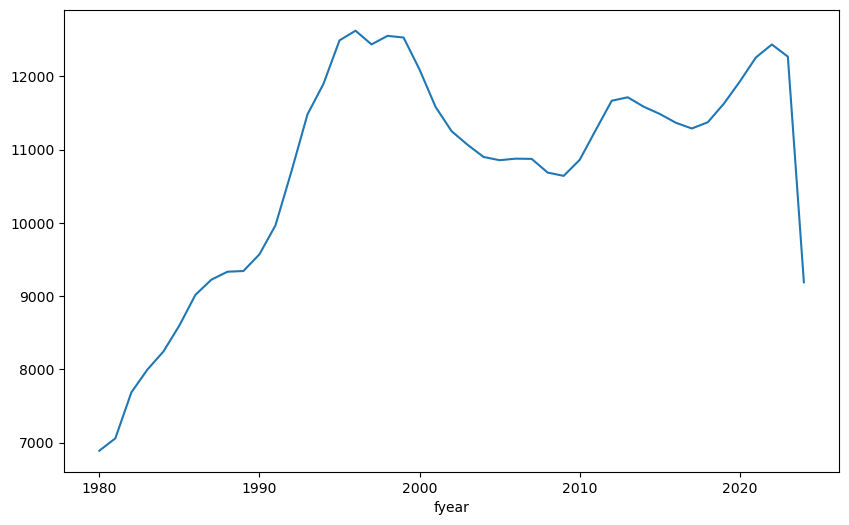

In [23]:
# Number of companies have declined since late 1990s
compa.groupby(['fyear']).gvkey.nunique().plot()

<Axes: xlabel='fyear'>

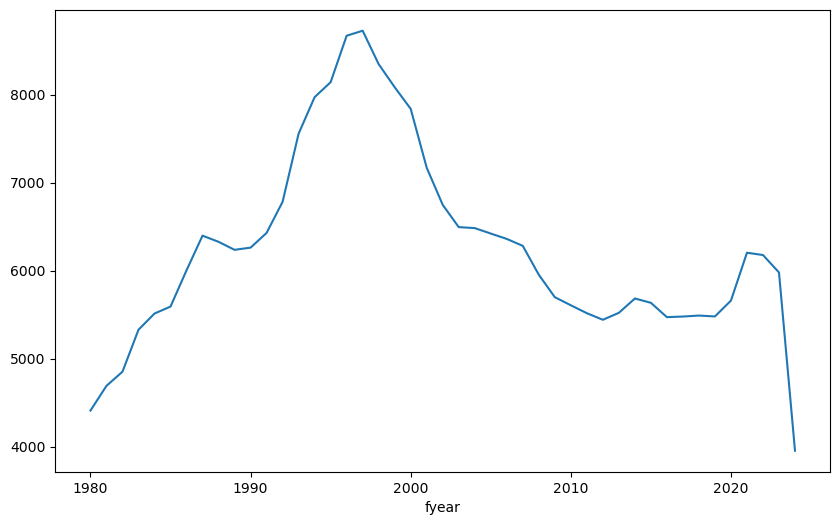

In [24]:
# So does the number of traded stocks
df.groupby(['fyear']).permco.nunique().plot()

* Why do we see a decline in the number of publicly listed stocks?
* Take a look at [Doidge, Karolyi, Stulz (2017)](https://www.sciencedirect.com/science/article/pii/S0304405X1630232X)

## Special Cases

In [25]:
# Should we have duplicated entries for (permco, datadate)?
print(df.duplicated(subset=['permco', 'datadate']).sum())

32919


In [26]:
df.groupby(['permno','datadate']).gvkey.nunique().max()

1

### Many PERMCOs for One GVKEY

In [27]:
df.groupby('gvkey').permco.nunique().max()

4

In [28]:
df.loc[df.gvkey==df.groupby('gvkey').permco.nunique().idxmax(), ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']]

,datadate,permno,permco,gvkey,conm,at
323316,1995-12-31,81875,4388,032280,STARZ,2517.636
323317,1995-12-31,82187,4388,032280,STARZ,2517.636
323326,1996-12-31,81875,4388,032280,STARZ,3058.952
323327,1996-12-31,82187,4388,032280,STARZ,3058.952
323336,1997-12-31,81875,4388,032280,STARZ,5038.561
323337,1997-12-31,82187,4388,032280,STARZ,5038.561
323346,1998-12-31,81875,4388,032280,STARZ,20348.000
323347,1998-12-31,82187,4388,032280,STARZ,20348.000
323358,1999-12-31,86746,20103,032280,STARZ,58684.000
323359,1999-12-31,86747,20103,032280,STARZ,58684.000


### Many GVKEYs for one PERMCO

In [29]:
df[df['at'].notnull()].groupby('permco').gvkey.nunique().max()

5

In [30]:
pp = df[df['at'].notnull()].groupby('permco').gvkey.nunique().idxmax()
df.loc[df.permco==pp, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
394677,1994-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
394678,1995-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
170136,1996-12-31,10324,8243,012233,GENZYME CORP,1229.519
394679,1996-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,42.593
170137,1997-12-31,10324,8243,012233,GENZYME CORP,1203.056
394680,1997-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,56.818
393663,1998-12-31,86426,8243,117298,GENZYME MOLECULAR ONCOLOGY,35.952
394681,1998-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,18.954
170138,1998-12-31,10324,8243,012233,GENZYME CORP,1646.307
394682,1999-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,19.648


### Many GVKEYs for one PERMCO for the Same Date

In [31]:
df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().max()

4

In [32]:
pp = df[df['at'].notnull()].groupby(['permco','datadate']).gvkey.nunique().idxmax()
pp

(8243, Timestamp('1999-12-31 00:00:00'))

In [33]:
df.loc[df.permco==8243, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
394677,1994-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
394678,1995-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,NaN
170136,1996-12-31,10324,8243,012233,GENZYME CORP,1229.519
394679,1996-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,42.593
170137,1997-12-31,10324,8243,012233,GENZYME CORP,1203.056
394680,1997-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,56.818
393663,1998-12-31,86426,8243,117298,GENZYME MOLECULAR ONCOLOGY,35.952
394681,1998-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,18.954
170138,1998-12-31,10324,8243,012233,GENZYME CORP,1646.307
394682,1999-12-31,81154,8243,118653,GENZYME TISSUE REPAIR,19.648


In [34]:
df.loc[df.permco==54311, ['datadate', 'permno', 'permco','gvkey', 'conm', 'at']].sort_values(['datadate'])

,datadate,permno,permco,gvkey,conm,at
226961,2013-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,34542.0
226962,2013-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,34542.0
226969,2014-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
226970,2014-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
226971,2014-12-31,14811,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,31207.0
226977,2015-12-31,13757,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
226978,2015-12-31,13758,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
226979,2015-12-31,14811,54311,017010,LIBERTY MEDIA SIRIUSXM GROUP,29798.0
286260,2016-12-31,14811,54311,027187,LIBERTY MEDIA FORMULA ONE,2995.0
286258,2016-12-31,13757,54311,027187,LIBERTY MEDIA FORMULA ONE,2995.0


## Merge

In [35]:
crspm.columns

Index(['date', 'permno', 'permco', 'prc', 'vol', 'ret', 'retx', 'cfacpr',
       'cfacshr', 'comnam', 'dlret', 'dlretx', 'exchcd', 'naics', 'cusip',
       'ncusip', 'shrcd', 'shrout', 'siccd', 'ticker', 'retadj', 'me', 'mesum',
       'melag_nt', 'melag', 'rankyear', 'mdate', 'rf'],
      dtype='object')

In [36]:
df.columns

Index(['gvkey', 'datadate', 'conm', 'tic', 'cusip', 'fyear', 'fyr', 'at',
       'capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch', 'dltt', 'dp', 'ib',
       'itcb', 'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl',
       'pstkrv', 're', 'revt', 'sale', 'seq', 'sich', 'txdb', 'txdi', 'txditc',
       'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'se', 'ps', 'dt', 'be', 'cost',
       'op', 'opbe', 'at_lag', 'inv', 'fdiff', 'inv_capx', 'permno', 'permco',
       'linktype', 'linkdt', 'linkenddt'],
      dtype='object')

In [37]:
df['rankyear'] = df['datadate'].dt.year + 1
fdata = pd.merge(crspm,
                 df,
                 on = ['permno','rankyear' ],
                how='left')
fdata

,date,permno,permco_x,prc,vol,ret,retx,cfacpr,cfacshr,comnam,...,op,opbe,at_lag,inv,fdiff,inv_capx,permco_y,linktype,linkdt,linkenddt
0,1985-12-31,10000,7952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,1986-01-31,10000,7952,-4.37500,1771.0,NaN,NaN,1.0,1.0,OPTIMUM MANUFACTURING INC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
2,1986-02-28,10000,7952,-3.25000,828.0,-0.257143,-0.257143,1.0,1.0,OPTIMUM MANUFACTURING INC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,1986-03-31,10000,7952,-4.43750,1078.0,0.365385,0.365385,1.0,1.0,OPTIMUM MANUFACTURING INC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,1986-04-30,10000,7952,-4.00000,957.0,-0.098592,-0.098592,1.0,1.0,OPTIMUM MANUFACTURING INC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033516,2024-08-30,93436,53453,214.11000,16108365.0,-0.077391,-0.077391,1.0,1.0,TESLA INC,...,13402.0,0.213973,82338.0,0.294882,1.0,0.108079,53453.0,LC,2010-06-29,NaT
4033517,2024-09-30,93436,53453,261.63000,16042065.0,0.221942,0.221942,1.0,1.0,TESLA INC,...,13402.0,0.213973,82338.0,0.294882,1.0,0.108079,53453.0,LC,2010-06-29,NaT
4033518,2024-10-31,93436,53453,249.85001,19014312.0,-0.045025,-0.045025,1.0,1.0,TESLA INC,...,13402.0,0.213973,82338.0,0.294882,1.0,0.108079,53453.0,LC,2010-06-29,NaT
4033519,2024-11-29,93436,53453,345.16000,20821313.0,0.381469,0.381469,1.0,1.0,TESLA INC,...,13402.0,0.213973,82338.0,0.294882,1.0,0.108079,53453.0,LC,2010-06-29,NaT


## For next class

**(FI)nance (RE)search Python Tools: fire_pytools**

* To make our lives easier, we will use a fire_pytools package.

* Written by our alumni, Lira Mota
    - Download the package [here](https://bitbucket.org/liramota/fire_pytools/src)

* This is a collection of useful functions in finance research.
    - Direct download of CRSP and Compustat from WRDS server
    - Direct download of Ken French data library
    - Portfolio sorts tools
    - Replicate Fama and French factors